# Attributing MI to specific dimensions by inspecting cross-decoders

Here, we explore one way of "interpreting" an MI estimate. Different dimensions of a variable may contribute more to MI than others. To get a sense of how much each dimension contributes to MI, we can inspect the element-wise error in our cross predictive models.

Intuitively, if a dimension is poorly cross-predicted, then it does not contribute to the MI. However, if a dimension is well predicted, it does not necessarily contain mutual information. For example, if a dimension is always 0, it will be well-predicted, but not contribute MI. Yet, the prediction error is often a useful way of pulling out important dimensions. Here we show one example, on the 0-1 MNIST dataset.

In [1]:
import time
import os

from lmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import tensorflow as tf
from tqdm.notebook import tqdm

from scipy.stats import kendalltau

from keras.datasets import mnist

import torch

torch.manual_seed(2121)
np.random.seed(2121)

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Labels: (0, 0)


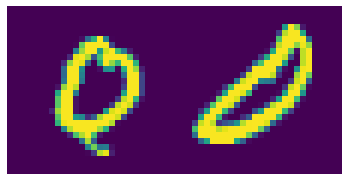

Labels: (1, 1)


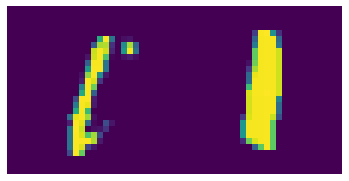

Sanity check (percent identical labels, should be ~0.75): 0.752400


In [2]:
(x_train, y_train), _ = mnist.load_data()

X_data, Y_data = [], []
labels = []

for i in range(2):
    imgs = [x[0] for x in x_train[np.argwhere(y_train == i)]]
    X_data += imgs[:2500]
    Y_data += imgs[2500:5000]
    labels += [i]*2500

X_data = np.array([x.flatten() for x in X_data])
Y_data = np.array([x.flatten() for x in Y_data])
labels = np.array(labels)

assert(len(X_data) == len(Y_data))

inds = np.arange(len(labels))
np.random.shuffle(inds)

X_data = X_data[inds]
Y_data = Y_data[inds]
labels = labels[inds]

def generate_dataset(percent_shuffle, N_samples=10**5):
    """
    """
    
    Xs = X_data[:N_samples].copy()
    Ys = Y_data[:N_samples].copy()
    Lx = labels[:N_samples].copy()
    Ly = labels[:N_samples].copy()
    
    rows_to_shuffle = int(percent_shuffle*len(labels))    
    # get identical shuffles
    # thanks to https://stackoverflow.com/questions/4601373/
    # better-way-to-shuffle-two-numpy-arrays-in-unison
    rng_state = np.random.get_state()
    np.random.shuffle(Xs[:rows_to_shuffle])
    np.random.set_state(rng_state)
    np.random.shuffle(Lx[:rows_to_shuffle])
    
    return Xs, Ys, Lx, Ly

rcParams["figure.figsize"] = (2,1)

Xs, Ys, Lx, Ly = generate_dataset(0.5)
for k in np.random.choice(np.arange(len(Xs)), 2):
    print("Labels: (%d, %d)"%(Lx[k], Ly[k]))
    plt.imshow(np.hstack((Xs[k].reshape(28, 28), Ys[k].reshape(28,28))))
    plt.axis('off')
    plt.show()
    
print("Sanity check (percent identical labels, should be ~0.75): %f"
      %(sum(Lx == Ly)/len(Lx)))

In [3]:
Xs, Ys, Lx, Ly = generate_dataset(0)
est, emb, model = lmi.lmi(Xs, Ys, epochs=500,
                           regularizer='models.AECross', 
                                   quiet=False)


/home/gokul/latent-mutual-information/analysis/lmi/lmi.py:179: RuntimeWarning: invalid value encountered in divide
  Xs = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
/home/gokul/latent-mutual-information/analysis/lmi/lmi.py:180: RuntimeWarning: invalid value encountered in divide
  Ys = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()


  0%|          | 0/500 [00:00<?, ?Epoch/s]

Training stopped at epoch  399
Validation loss: 1.1615991115570068


In [4]:
Xs = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
Ys = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()
with torch.no_grad():
    Zx, Zy = model.encode(Xs, Ys)
    cXh, cYh = model.cross_decode(Zx, Zy)

/tmp/ipykernel_328792/2042423546.py:1: RuntimeWarning: invalid value encountered in divide
  Xs = torch.from_numpy(np.nan_to_num((Xs - Xs.mean(axis=0)) / Xs.std(axis=0))).float().cuda()
/tmp/ipykernel_328792/2042423546.py:2: RuntimeWarning: invalid value encountered in divide
  Ys = torch.from_numpy(np.nan_to_num((Ys - Ys.mean(axis=0)) / Ys.std(axis=0))).float().cuda()


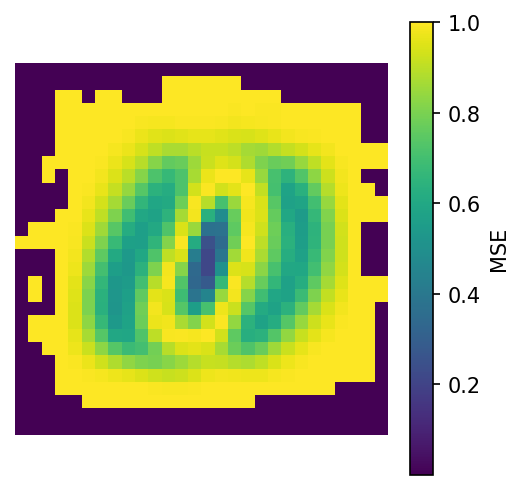

In [8]:
el_wise = ((cYh - Ys)**2).mean(axis=0).cpu().numpy()
rcParams['figure.figsize'] = (4,4)
rcParams['figure.dpi']= 150
plt.imshow(el_wise.reshape(28, 28))
cbar = plt.colorbar()
cbar.set_label('MSE')
plt.axis('off')
plt.show()

In [9]:
np.save("../results/A_elwise_MSE.npy", el_wise.reshape(28, 28))